This paper evaluates the PatchTST forecasting model on five different datasets, for the HINT paper.

The model's configuration parameters are optimized with Hyperopt.

## 1. Installing packages

In [1]:
%%capture
!pip install datasetsforecast
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git
!pip install hyperopt
!git clone https://github.com/dluuo/HINT.git

In [2]:
import numpy as np
import pandas as pd

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import GMM, sCRPS
from neuralforecast.auto import (
    AutoPatchTST
)

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, MinTrace, TopDown
from hierarchicalforecast.utils import HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import scaled_crps

from ray import tune

#import wrangled datasets
from HINT.src.data.data import HierarchicalDataset

## 2. Load hierarchical dataset

This detailed Australian Tourism Dataset comes from the National Visitor Survey, managed by the Tourism Research Australia, it is composed of 555 monthly series from 1998 to 2016, it is organized geographically, and purpose of travel. The natural geographical hierarchy comprises seven states, divided further in 27 zones and 76 regions. The purpose of travel categories are holiday, visiting friends and relatives (VFR), business and other. The MinT (Wickramasuriya et al., 2019), among other hierarchical forecasting studies has used the dataset it in the past. The dataset can be accessed in the [MinT reconciliation webpage](https://robjhyndman.com/publications/mint/), although other sources are available.

| Geographical Division | Number of series per division | Number of series per purpose | Total |
|          ---          |               ---             |              ---             |  ---  |
|  Australia            |              1                |               4              |   5   |
|  States               |              7                |              28              |  35   |
|  Zones                |             27                |              108             |  135  |
|  Regions              |             76                |              304             |  380  |
|  Total                |            111                |              444             |  555  |


In [3]:

hdataset = HierarchicalDataset()
data = hdataset.load_process_data(dataset='Wiki2')

horizon = data['seasonality']
seasonality = data['seasonality']
hier_idxs = data['hier_idxs']
hier_levels = data['hier_levels']
freq = data['freq']
Y_df = data['Y_df']
S_df = data['S_df']
tags = data['tags']
n_series = len(S_df)

100%|██████████| 1.30M/1.30M [00:01<00:00, 982kiB/s]


In [4]:
Y_df.head()

,unique_id,ds,y,weekday,monthday,yearday
0,Total,2016-01-01,156508,0.166667,-0.500000,-0.500000
1,Total,2016-01-02,129902,0.333333,-0.466667,-0.497260
2,Total,2016-01-03,138203,0.500000,-0.433333,-0.494521
3,Total,2016-01-04,115017,-0.500000,-0.400000,-0.491781
4,Total,2016-01-05,126042,-0.333333,-0.366667,-0.489041


Visualize the aggregation matrix.

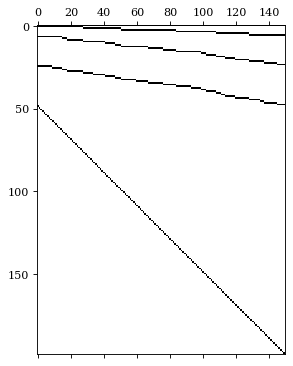

In [5]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Split the dataframe in train/test splits.

In [6]:
def sort_hier_df(Y_df, S_df):
    # sorts unique_id lexicographically
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S_df.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
    return Y_df

Y_df = sort_hier_df(Y_df, S_df)

In [7]:
Y_test_df = Y_df.groupby('unique_id').tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

## 3. Fit and Predict Models


In [8]:
%%capture
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

config = {
            "scaler_type": tune.choice(['robust']),
            "learning_rate": tune.choice([1e-3, 5e-4, 1e-4]),                                         # Initial Learning rate
            "max_steps": tune.choice([500, 1000, 1500, 2000, 2500, 3000]),                            # Number of SGD steps
            "input_size": tune.choice([2*seasonality, 3*seasonality, 4*seasonality]),                 # input_size = multiplier * horizon
            "early_stop_patience_steps": tune.choice([5]),
            "num_lr_decays": tune.choice([-1, 3]),
            "random_seed": tune.randint(1, 5),
            "hidden_size": tune.choice([64, 128, 256]),
            "valid_batch_size": tune.choice([n_series]),
            "val_check_steps": tune.choice([100]),                                                    # Compute validation every 100 steps
            "early_stop_patience_steps": tune.choice([3]),
        }

#fit/predict
model = AutoPatchTST(h=horizon,
                    config=config,
                    loss=GMM(n_components=10, quantiles=quantiles),
                    valid_loss=sCRPS(quantiles=quantiles),
                    num_samples=20)

nf = NeuralForecast(models=[model], freq=freq)
nf.fit(df=Y_train_df, val_size=horizon)
Y_hat_nf = nf.predict()

2023-10-12 02:10:07,401	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-12 02:10:09,992	INFO tune.py:228 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2023-10-12 02:10:10,000	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [9]:
def get_hierarchical_crps(data, Y, Y_hat, q_to_pred):
    hier_idxs   = data['hier_idxs']
    crps_list = []
    for i, idxs in enumerate(hier_idxs):
        # Get the series specific to the hierarchical level
        y     = Y[idxs, :]
        y_hat = Y_hat[idxs, :, :]

        crps  = scaled_crps(y, y_hat, q_to_pred)
        crps_list.append(crps)

    return crps_list

In [10]:
Y_hat_nf

,ds,AutoPatchTST,AutoPatchTST-lo-98.0,AutoPatchTST-lo-96.0,AutoPatchTST-lo-94.0,AutoPatchTST-lo-92.0,AutoPatchTST-lo-90.0,AutoPatchTST-lo-88.0,AutoPatchTST-lo-86.0,AutoPatchTST-lo-84.0,...,AutoPatchTST-hi-80.0,AutoPatchTST-hi-82.0,AutoPatchTST-hi-84.0,AutoPatchTST-hi-86.0,AutoPatchTST-hi-88.0,AutoPatchTST-hi-90.0,AutoPatchTST-hi-92.0,AutoPatchTST-hi-94.0,AutoPatchTST-hi-96.0,AutoPatchTST-hi-98.0
unique_id,,,,,,,,,,,,,,,,,,,,,
Total,2016-12-25,112791.828125,-207179.890625,-134372.609375,-57343.910156,6123.823730,31140.859375,46884.984375,52688.933594,58018.656250,...,166286.218750,175079.640625,188307.625000,197379.546875,212305.828125,226285.250000,254426.656250,321446.375000,386771.750000,416352.968750
Total,2016-12-26,102409.460938,-9752.244141,34986.574219,37474.640625,38695.500000,39878.460938,40778.382812,41488.351562,42234.492188,...,150835.843750,158047.421875,163975.156250,166948.578125,172600.468750,179001.968750,187607.171875,210796.906250,231074.796875,280062.968750
Total,2016-12-27,114106.132812,-78923.929688,6646.184082,26892.201172,30053.623047,31910.656250,32992.410156,33822.492188,34567.523438,...,185732.812500,193723.171875,203536.281250,218162.265625,233280.031250,245879.546875,286049.187500,312767.375000,349970.906250,393289.156250
Total,2016-12-28,99436.437500,-176454.093750,-174844.687500,-173450.343750,-172475.656250,-171653.046875,-170703.296875,-169052.718750,-167658.890625,...,196841.062500,202701.375000,207876.125000,217986.906250,232169.500000,241531.953125,262081.656250,283404.187500,327446.812500,348908.531250
Total,2016-12-29,104031.687500,-159335.843750,-93814.578125,-56370.625000,-54163.972656,-53057.691406,-52136.843750,-51479.722656,-50792.988281,...,192353.218750,203908.859375,210662.000000,220040.046875,239018.703125,265438.843750,278022.375000,305782.312500,359559.656250,400912.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zh_MOB_AAG_138,2016-12-27,65.585800,-48.021431,-17.161163,25.364599,42.245434,44.523376,45.278378,46.033596,46.591473,...,81.641418,83.401596,86.345482,88.739342,91.461372,102.881363,109.287102,131.887589,170.281158,213.332275
zh_MOB_AAG_138,2016-12-28,59.072056,-33.654697,-32.490265,-32.103291,-31.707848,-31.328791,-30.848705,-30.332479,-29.848238,...,90.356750,97.080269,100.742203,108.734421,112.399719,115.793114,125.705330,135.019440,151.094040,172.762497
zh_MOB_AAG_138,2016-12-29,58.700699,-22.849369,-5.899207,0.666444,1.854584,2.220716,2.813658,3.341944,3.864925,...,93.516052,98.467468,102.140961,110.733490,116.393127,123.916077,132.639771,144.293243,159.852417,175.705643


## 4. Reconcile Predictions
With minimal parsing, we can reconcile the raw output predictions with different HierarchicalForecast reconciliation methods.

In [11]:
reconcilers = [
    BottomUp(),
    # TopDown(method='average_proportions'),
    # TopDown(method='proportion_averages'),
    MinTrace(method='ols'),
    # MinTrace(method='wls_var'),
    # MinTrace(method='mint_shrink'),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

num_seeds = 10
Y_rec_df = hrec.bootstrap_reconcile(Y_hat_df=Y_hat_nf,
                                    Y_df=Y_train_df,
                                    S_df=S_df, tags=tags,
                                    level=level,
                                    intervals_method='normality',
                                    num_samples=10, num_seeds=num_seeds)
Y_rec_df = Y_rec_df.sort_values(by=['seed', 'unique_id', 'ds'])

## 5. Evaluation

To evaluate we use a scaled variation of the CRPS, as proposed by Rangapuram (2021), to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

$$ \mathrm{sCRPS}(\hat{F}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq $$

In [12]:
rec_model_names_nf = ['AutoPatchTST/BottomUp',
                    #   'AutoPatchTST/TopDown_method-average_proportions',
                    #   'AutoPatchTST/TopDown_method-proportion_averages',
                      'AutoPatchTST/MinTrace_method-ols',
                    #   'AutoPatchTST/MinTrace_method-wls_var',
                    #   'AutoPatchTST/MinTrace_method-mint_shrink'
                      ]

n_quantiles = len(quantiles)
n_series = len(S_df)

for name in rec_model_names_nf:
    print(name)
    quantile_columns = [col for col in Y_rec_df.columns if (name+'-lo') in col or (name+'-hi') in col]
    y_rec  = Y_rec_df[quantile_columns].values
    y_test = Y_test_df['y'].values

    y_rec  = y_rec.reshape(num_seeds, n_series, horizon, n_quantiles)
    y_test = y_test.reshape(n_series, horizon)

    level_model_crps = []
    for seed_idx in range(num_seeds):
        _y_rec = y_rec[seed_idx, :, :, :]
        level_model_crps.append(get_hierarchical_crps(data, Y=y_test, Y_hat=_y_rec, q_to_pred=quantiles))
    level_model_crps = np.array(level_model_crps)
    means = np.mean(level_model_crps.T, axis=1)
    stds = 1.96 * np.std(level_model_crps.T, axis=1)
    level_model_crps = [f'{mean:.4f}±{std:.4f}' for mean, std in zip(means, stds)]
    for crps in level_model_crps:
        print(crps)

AutoPatchTST/BottomUp
0.3581±0.0000
0.1483±0.0000
0.2597±0.0000
0.3961±0.0000
0.4046±0.0000
0.5818±0.0000
AutoPatchTST/MinTrace_method-ols
0.4417±0.0000
0.2030±0.0000
0.2944±0.0000
0.4146±0.0000
0.4614±0.0000
0.8348±0.0000
